Matteo Tortora, PhD Student, m.tortora@unicampus.it

## Overview

In this tutorial, we will cover:

1. Feature detection: LoG, Harris Corner Detector;
3. Feature description: SIFT, HOG, LBP;
5. Image Panorama Stiching;
6. Now it's your turn.

## Laplacian of Gaussian (LoG) filter

In the previous lab class, we discuss Sobel, a first-order derivative filters. Today, we will discuss the Laplacian of Gaussian (LoG), a second-order derivative filter.

(-0.5, 2851.5, 1841.5, -0.5)

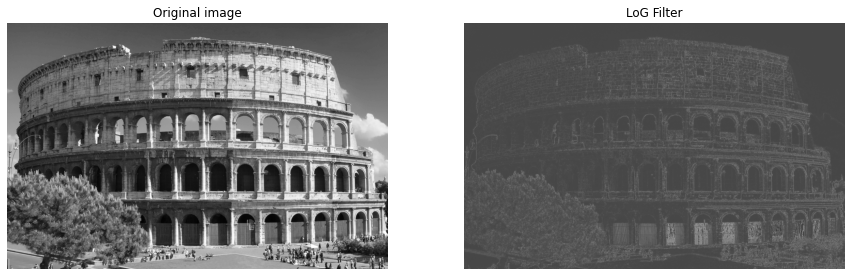

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


img = cv2.imread('colosseum_left.png', 1) # Read BGR image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale colourspace

img_elab = cv2.GaussianBlur(img_gray, (3, 3), 0.1) # Let's apply gaussian filter
img_elab = cv2.Laplacian(img_elab, -1, 3) # Let's apply laplacian filter

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(img_gray, cmap='gray')
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('LoG Filter')
plt.imshow(img_elab+70, cmap='gray')
plt.axis('off')

## Harris Corner Detector

Corners are regions in the image with large variation in intensity in all the directions. 

In 1998, Chris Harris proposed an early attempt to find these corners, so now it is called Harris Corner Detector. 
For each pixel $(x,y)$ it calculates a $2\times2$ gradient covariance matrix $M(x,y)$ over a $blockSize\times blockSize$ neighborhood. Then, it computes the following characteristic:

$R(x,y)=detM^{(x,y)}−k⋅(trM^{(x,y)})^2$

where:
* $det(M) = \lambda_1 \lambda_2$
* $trace(M) = \lambda_1 + \lambda_2$
* $\lambda_1$ and $\lambda_2$ are the eigen values of M

Corners in the image can be found as the local maxima of this response map.
So the values of these eigen values decide whether a region is corner, edge or flat:

* When $|R|$ is small, which happens when $\lambda_1$ and $\lambda_2$ are small, the region is flat.
* When $R<0$, which happens when $\lambda_1 >> \lambda_2$ or vice versa, the region is edge.
* When $R$ is large, which happens when $\lambda_1$ and $\lambda_2$ are large and $\lambda_1 \sim \lambda_2$, the region is a corner.

It can be represented in a nice picture as follows:

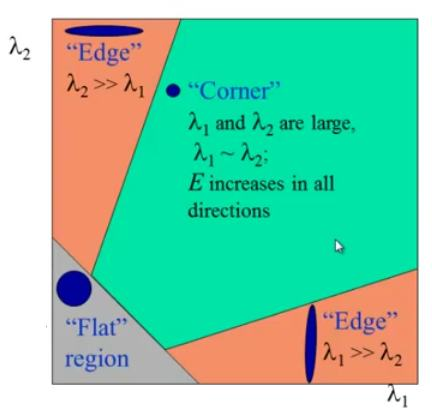


OpenCV implements `cv2.cornerHarris()` function to apply a Harris operator. Let's see its syntax:

`cv2.cornerHarris(img, blockSize, ksize, k)`

where:

* *img* - Input image, it should be grayscale and float32 type.
* *blockSize* - It is the size of neighbourhood considered for corner detection.
* *ksize* - Aperture parameter of Sobel derivative used.
* *k* - Harris detector free parameter in the equation.

(-0.5, 899.5, 899.5, -0.5)

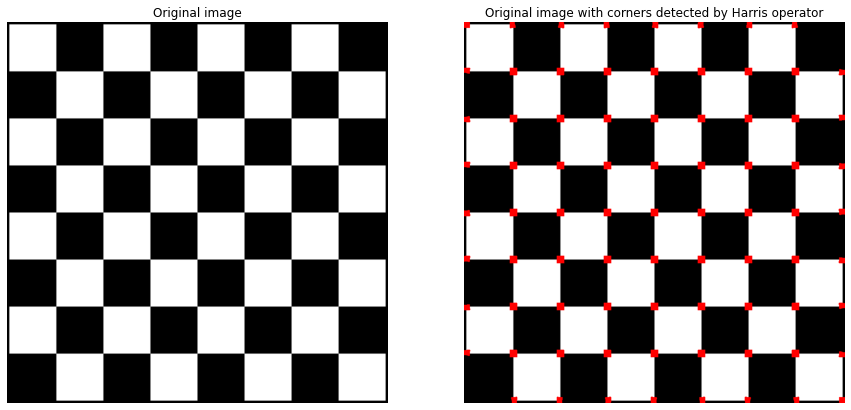

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('chessboard.png', 1) # Read original image in BGR mod
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale colourspace

img_gray = img_gray.astype('float32') # Convert to float32 type
corners = cv2.cornerHarris(img_gray, 15, 3, 0.04) # Apply Harris operator


#result is dilated for marking the corners, not important
corners = cv2.dilate(corners, None)

# Threshold for an optimal value, it may vary depending on the image
img_elab = img.copy()
img_elab[corners>0.1 * corners.max()] = [0, 0, 255] # Let's colour the corners red


# Plot results
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Original image with corners detected by Harris operator')
plt.imshow(cv2.cvtColor(img_elab, cv2.COLOR_BGR2RGB))
plt.axis('off')

## SIFT

Now that we can detect the image’s keypoints, we have to describe them in order to match them between different images with the same elements.

Scale Invariant Feature Transform (SIFT) is a method used to extract keypoints and compute its descriptors.

OpenCV implements the following `cv2.SIFT()` method.

In [ ]:
!!pip install -U opencv-contrib-python==3.4.2.17

['Requirement already satisfied: opencv-contrib-python==3.4.2.17 in /usr/local/lib/python3.7/dist-packages (3.4.2.17)',
 'Requirement already satisfied: numpy>=1.14.5 in /usr/local/lib/python3.7/dist-packages (from opencv-contrib-python==3.4.2.17) (1.19.5)']

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("house.png", 1) # Read image in BGR mod
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

kp = sift.detect(img_gray, None)

OpenCV also provides cv2.drawKeyPoints() function which draws the small circles on the locations of keypoints. If you pass a flag, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to it, it will draw a circle with size of keypoint and it will even show its orientation. See below example.

(-0.5, 511.5, 442.5, -0.5)

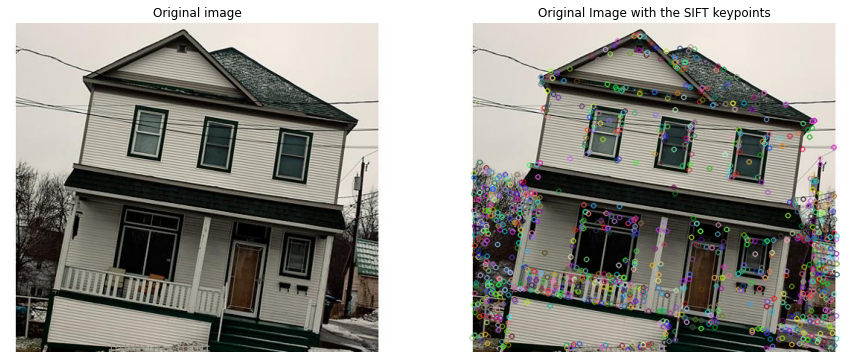

In [ ]:
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(cv2.cvtColor(img,  cv2.COLOR_BGR2RGB))
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Original Image with the SIFT keypoints')
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(img, kp, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), cv2.COLOR_BGR2RGB))
plt.axis('off')

You can call `sift.compute()` which computes the descriptors from the keypoints we have found.

In [ ]:
kp, des = sift.compute(img_gray, kp)

## HOG (Histogram of Oriented Gradients)

The HoG descriptor finds robust feature set that allows object form to be discriminated. The Histogram of Oriented Gradient (HOG) feature descriptor is popular for object detection. The HOG algorithm consists of the following steps:
1. (optional) global image normalization
2. computing the gradient image in row and col
3. computing gradient histograms
4. normalizing across blocks
5. flattening into a feature vector

Scikit-image implements the method to compute the HOG. Its syntax is the following:

`hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False)`

where:
* *image*: Input image.
* *orientations*: Number of orientation bins.
* *pixels_per_cell2*: Size (in pixels) of a cell.
* *cells_per_block2*: Number of cells in each block.
* *block_normstr*: Block normalization method:
* *visualizebool*: If  return an image of the HOG.

OpenCV also implements the HOG operator, but only returns the feature vector. In fact, it does not allow the HOG to be displayed.

(-0.5, 599.5, 400.5, -0.5)

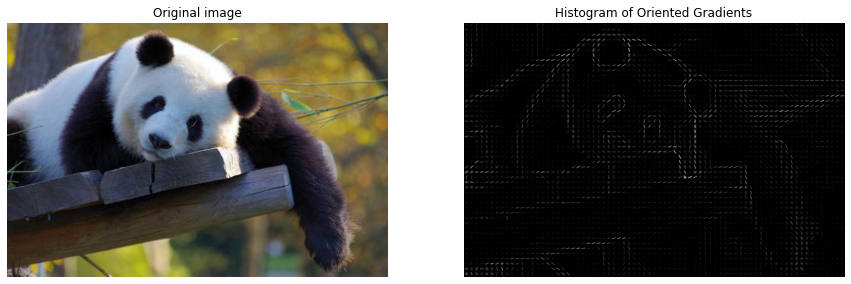

In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("panda.png", 1) # Read image in BGR mod

fd, hog_image = hog(img, orientations=180, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True)
# fd: it is the feature vector, we can use this vector for classification task

# Plot results
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Histogram of Oriented Gradients')
plt.imshow(hog_image+70, cmap='gray')
plt.axis('off')

## Local Binary Pattern (LBP)

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala.

Unlike Haralick texture features that compute a global representation of texture based on the Gray Level Co-occurrence Matrix, LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels.

Scikit-image implements the following method to compute the LBP:

`local_binary_pattern(image, P, R, method='default')`

where:
* *image*: Graylevel image.
* *P*: Number of circularly symmetric neighbour set points (quantization of the angular space).
* *R*: Radius of circle (spatial resolution of the operator).
* *method*: Method to determine the pattern. Where:

  * *default*: original local binary pattern which is gray scale but not rotation invariant.
  * *ror*: extension of default implementation which is gray scale and rotation invariant.
  * *uniform*: improved rotation invariance with uniform patterns and
finer quantization of the angular space which is gray scale and rotation invariant.
  * *nri_uniform*: non rotation-invariant uniform patterns variant
which is only gray scale invariant.
  * *var*: rotation invariant variance measures of the contrast of local image texture which is rotation but not gray scale invariant.

(-0.5, 2851.5, 1841.5, -0.5)

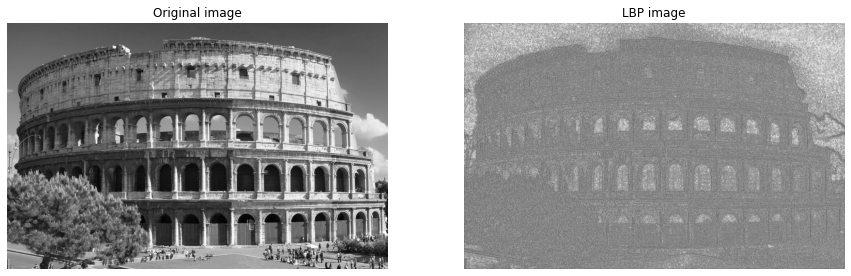

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

img = cv2.imread('colosseum_left.png', 0) # Read grayscale image

# settings for LBP
radius = 1
n_points = 8 * radius

lbp = local_binary_pattern(img, n_points, radius, 'uniform')

# Plot results
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('LBP image')
plt.imshow(lbp, cmap='gray')
plt.axis('off')

Let's plot the histogram

Text(0.5, 0, 'Patterns')

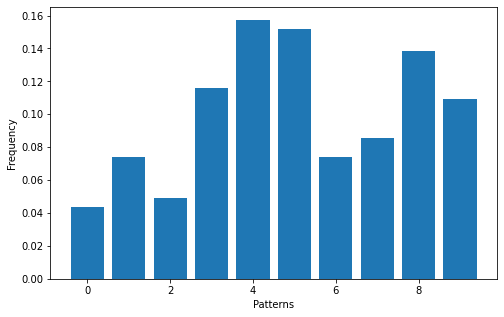

In [ ]:
n_bins = int(np.nanmax(lbp) + 1) # For each method
#n_bins = numPoints + 2 # Only in the case of LBP with uniform method
(hist, _) = np.histogram(lbp.ravel(), bins = n_bins, range = (0, n_bins), density=True)
# hist rapresents our feature vectore of the desidered image

# Plot results
f = plt.figure(figsize=(8,5))

plt.bar(range(n_bins), hist)
plt.ylabel("Frequency")
plt.xlabel("Patterns")

## Homography 

In the field of computer vision, any two images of the same planar surface in space are related by a homography. 

The transformation of an image from one projective plane to another may involve translation, scaling (up or down), rotation, shear, and changes in aspect ratio.

Homography matrix describes the transformation between points in one picture and a related neighboring picture (different perspective), i.e. the transformation from one set of coordinates to the other.

## Image Panorama Stiching

Let's see how to stitch two or more images together to make a panorama using OpenCV.


In [ ]:
# Let's restart the colab runtime and run the following command.
!pip install -U opencv-contrib-python==3.4.2.17
# In this way we are taking an older version of OpenCV that works better for our task.

(-0.5, 2686.5, 2019.5, -0.5)

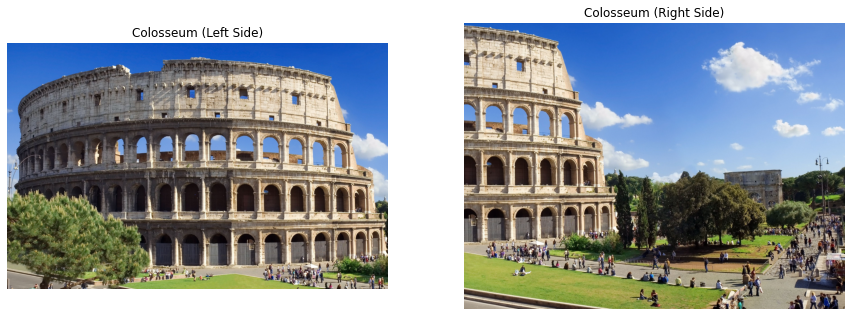

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_left = cv2.imread("colosseum_left.png", 1) # Read image in BGR mod
img_right = cv2.imread("colosseum_right.png", 1) # Read image in BGR mod

img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Colosseum (Left Side)')
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Colosseum (Right Side)')
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [ ]:
# find the key points and descriptors with SIFT
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_left_gray, None)
kp2, des2 = sift.detectAndCompute(img_right_gray, None)

# kp is a list of structured arrays (like the struct in Matlab)

(-0.5, 2686.5, 2019.5, -0.5)

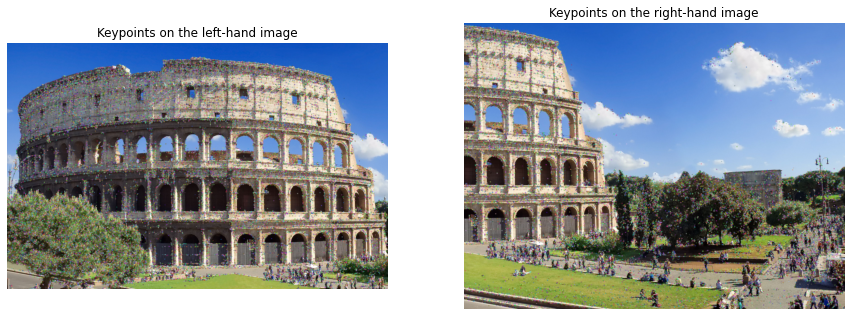

In [ ]:
# Let's highlight the keypoints

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Keypoints on the left-hand image')
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(img_left, kp1, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), cv2.COLOR_BGR2RGB))
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Keypoints on the right-hand image')
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(img_right, kp2, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), cv2.COLOR_BGR2RGB))
plt.axis('off')

Let's apply a brute force matcher to associate common keypoints between left and right images

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

OpenCV implements the following `cv2.BFMatcher(normType, crossCheck)` object.

where:
* *normType*: It specifies the distance measurement to be used. By default, it is cv2.NORM_L2. It is good for SIFT, SURF etc (cv2.NORM_L1 is also there). For binary string based descriptors like ORB, BRIEF, BRISK etc, cv2.NORM_HAMMING should be used, which used Hamming distance as measurement. If ORB is using VTA_K == 3 or 4, cv2.NORM_HAMMING2 should be used.
* *crossCheck*: which is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistant result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.

In [ ]:
match = cv2.BFMatcher() # Let's create the BFMatcher object
matches = match.knnMatch(des1, des2, k=2) #  This method returns k best matches where k is specified by the user.

The result of `matches = bf.knnMatch(des1, des2)` line is a list of DMatch objects. This DMatch object has following attributes:

* *DMatch.distance* - Distance between descriptors. The lower, the better it is.
* *DMatch.trainIdx* - Index of the descriptor in train descriptors
* *DMatch.queryIdx* - Index of the descriptor in query descriptors
* *DMatch.imgIdx* - Index of the train image.

(-0.5, 5538.5, 2019.5, -0.5)

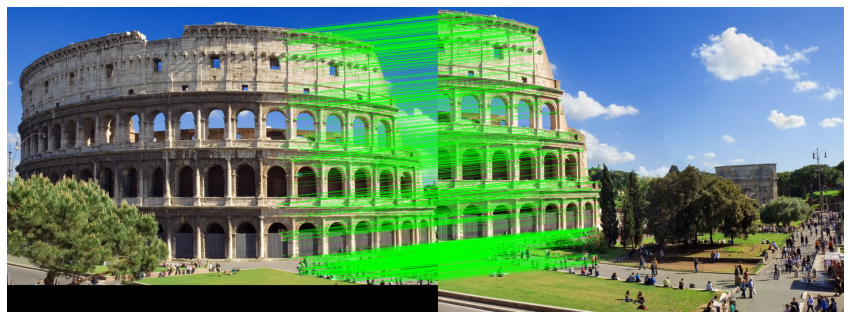

In [ ]:
# Let's select only matches that do not exceed a certain distance
good = []
for m, n in matches:
    if m.distance < 0.03 * n.distance:
        good.append(m)

# Let's draw matches in green color
draw_params = dict(matchColor = (0, 255, 0), 
                   singlePointColor = None,
                   flags = 2)

# Like we used cv2.drawKeypoints() to draw keypoints, cv2.drawMatches() helps us to draw the matches. 
# It stacks two images horizontally and draw lines from first image to second image showing best matches.
img_matches = cv2.drawMatches(img_left, kp1, img_right, kp2, good, None, **draw_params)

# Plot results
f = plt.figure(figsize=(15,15))

plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')

Images from different perspectives need to be transformed to a common perspective before they can be stitched together.

(-0.5, 2686.5, 2019.5, -0.5)

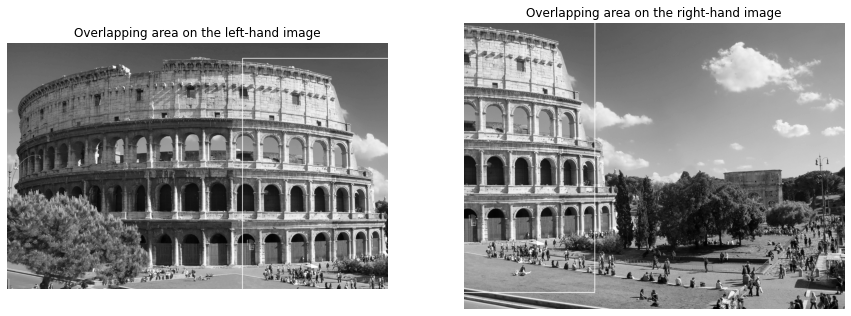

In [ ]:
# If the algorithm finds at least 10 optimal matches between the left and right images, 
# then homography and RANSAC are applied for stitching.
    
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    # Let's select the points in the left-hand image that comply with the conditions imposed on matches
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Let's select the points in the right-hand image that comply with the conditions imposed on matches
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Let's apply the homography and construct the matrix useful for overlapping the two images
    M1, mask1 = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    M2, mask2 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h1, w1 = img_left_gray.shape # Get size of the original image
    h2, w2 = img_right_gray.shape # Get size of the original image

    # Let's build a rectangle to highlight the overlap area between the two images.
    pts1 = np.float32([ [0,0],[0,h1-1],[w1-1,h1-1],[w1-1,0] ]).reshape(-1,1,2)
    dst1 = cv2.perspectiveTransform(pts1, M1) # Let's apply a transform using the M matrix from homography operator

    # Let's build a rectangle to highlight the overlap area between the two images.
    pts2 = np.float32([ [0,0],[0,h2-1],[w2-1,h2-1],[w2-1,0] ]).reshape(-1,1,2)
    dst2 = cv2.perspectiveTransform(pts2, M2) # Let's apply a transform using the M matrix from homography operator
    
    # Let's highlight the overlap area for each of the two images with a line
    img_left_gray = cv2.polylines(img_left_gray, [np.int32(dst1)], True, 255, 3, cv2.LINE_AA)
    img_right_gray = cv2.polylines(img_right_gray, [np.int32(dst2)], True, 255, 3, cv2.LINE_AA)

else:
    # If there are not enough matches, it means that the two images are not overlapping at any point, so stitching is not possible.
    print (f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")

# Let's highlight the overlapping area
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1).set_title('Overlapping area on the left-hand image')
plt.imshow(img_left_gray, cmap='gray')
plt.axis('off')

f.add_subplot(1, 2, 2).set_title('Overlapping area on the right-hand image')
plt.imshow(img_right_gray, cmap='gray')
plt.axis('off')

`warped_image = cv2.warpPerspective(image, homography_matrix, dimension_of_warped_image)`

(-0.5, 5538.5, 2019.5, -0.5)

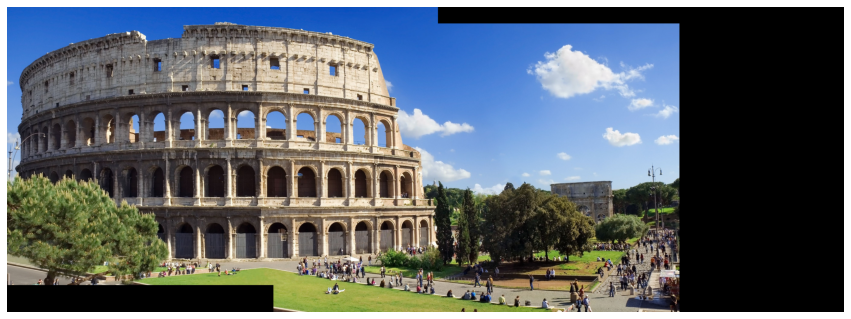

In [ ]:
# With warpPerspective, we place the right-hand image as the base on which the left-hand 
# image is overlapped on the basis of the mask previously created on the common points.
dst = cv2.warpPerspective(img_right, M1, (img_right.shape[1] + img_left.shape[1], img_right.shape[0]))
# The new shape will therefore have the same height as the right image (img_right.shape[0]), 
# and a width equal to the sum of the widths of the left and right images (img_right.shape[1]+img_left.shape[1]).

# Let's overlap the left image respecting the coordinates
dst[0:img_left.shape[0], 0:img_left.shape[1]] = img_left

f = plt.figure(figsize=(15,15))

plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [ ]:
# Let's create a function that removes excessive black spaces in the newly processed panorama

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

(-0.5, 4448.5, 2019.5, -0.5)

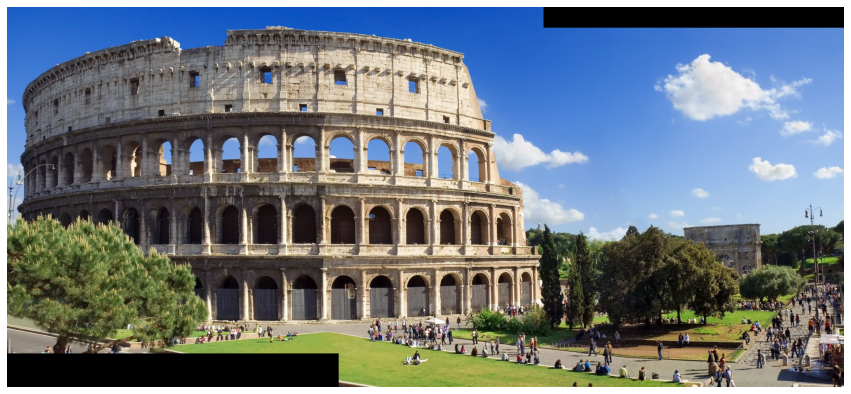

In [ ]:
# Let's plot results 

f = plt.figure(figsize=(15,15))

plt.imshow(cv2.cvtColor(trim(dst), cv2.COLOR_BGR2RGB))
plt.axis('off')